<a href="https://colab.research.google.com/github/DinisMartinho/Image-Colorizer/blob/main/Colab%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch, torchvision, tqdm, matplotlib.pyplot

In [2]:
# GPU is preferable to run the notebook.
use_collab_gpu = True #@param {type:"boolean"}

In [3]:
if use_collab_gpu == True:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  device = torch.device("cpu")

In [4]:
class DeepNeuralNetwork(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.inp_enc = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), stride=(2,2), padding=1)
    self.enc_lat = torch.nn.Conv2d(in_channels=32, out_channels=128, kernel_size=(3,3), stride=(2,2), padding=1)
    
    self.lat_lat = torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=1)

    self.lat_dec = torch.nn.ConvTranspose2d(in_channels=128, out_channels=32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    self.dec_dec = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=1)

    self.dec_out = torch.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    self.out_out = torch.nn.Conv2d(in_channels=16, out_channels=3, kernel_size=(3,3), stride=(1,1), padding=1)

    # [Activation Functions]
    self.sigmoid = torch.nn.Sigmoid()
    self.relu = torch.nn.ReLU(inplace=True)

  def forward(self, i):
    x = self.inp_enc(i)
    y = self.relu(x)
    y = self.enc_lat(y)
    y = self.relu(y)
    for i in range(32):
      y = self.lat_lat(y)
      y = self.relu(y)

    y = (self.lat_dec(y) * x)
    y = self.relu(y)

    for i in range(2):
      y = self.dec_dec(y)
      y = self.relu(y)

    y = (self.dec_out(y) * i)
    y = self.relu(y)
    y = self.out_out(y)
    y = self.sigmoid(y)

    return y

In [5]:
model = DeepNeuralNetwork().to(device)

In [6]:
# Load the pre-trained model from github. (https://github.com/DinisMartinho/Image-Colorizer)
model.load_state_dict(torch.load("./Pre-Trained Model.pth"))

<All keys matched successfully>

In [7]:
# Now scrape some images from the internet and test the model's efficacy.
!pip install -q jmd_imagescraper
from jmd_imagescraper.core import *

In [8]:
data_dir = "./data/images/"

search_results = ["mountains", "dogs", "cats", "old houses", "nature photos", "natural parks", "animals"]

In [9]:
for i in search_results:
  duckduckgo_search(data_dir, "images", i, max_results=10)

Duckduckgo search: mountains


Duckduckgo search: dogs


Duckduckgo search: cats


Duckduckgo search: old houses


Duckduckgo search: nature photos


Duckduckgo search: natural parks


Duckduckgo search: animals


In [10]:
# Apply the necessary transformations to your scraped images.
images_transforms = [torchvision.transforms.Resize(512),      # The model was trained on 256x256 images
  torchvision.transforms.CenterCrop(512),                     # but it scales well up to 512x512 images.
  torchvision.transforms.ToTensor()]
images = torchvision.datasets.ImageFolder(data_dir, transform=torchvision.transforms.Compose(images_transforms))

In [11]:
# Create the data loader to load our images.
data_loader = torch.utils.data.DataLoader(dataset=images, batch_size=1, num_workers=2, shuffle=True)

In [12]:
# Choose the number of batches of data to be processed and displayed by our model.
max_batch = 1

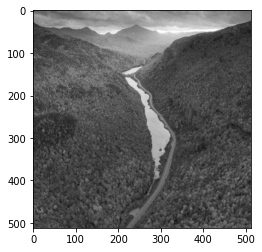

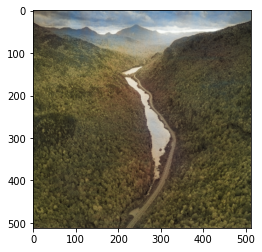

In [14]:
# Pass the images through our model.
it = 0
for i, (x, _) in (enumerate(data_loader)):
  it += 1
  GrayscaleImage = torchvision.transforms.Grayscale()(x).to(device)
  output_image = torchvision.transforms.functional.adjust_saturation(model(GrayscaleImage), 1.25)

  paths = ["grayscale.png", "output.png"]
  
  torchvision.utils.save_image(GrayscaleImage,  paths[0])
  torchvision.utils.save_image(output_image,    paths[1])
  
  for i in paths:
    img = matplotlib.image.imread(i)
    imgplot = matplotlib.pyplot.imshow(img)
    matplotlib.pyplot.show()

  if it >= max_batch:
    break

In [15]:
!nvidia-smi

Tue Nov  8 18:40:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W /  70W |   1496MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------